In [1]:
import pandas as pd

In [2]:
num_channels = 1496
channel_distance = 1.021095  # meters
channel_distance_ft = channel_distance * 3.280839895  # feet

In [3]:
file_path = '16B(78)-32 Well Survey/16B(78)-32 Final Survey Report.xlsx'

df = pd.read_excel(file_path, header=20)
df = df.drop(labels=[0, 1, 2], axis=0)
df.reset_index(drop=True, inplace=True)

In [4]:
df

,MD,INC,AZI,TVD,SSTVD,N/S,NORTHING,E/W,EASTING,VSEC,DLS
0,0,0,0,0,5447.65,0,13987765.96,0,1097907.09,0,0
1,25,0.22,52.11,25,5422.65,0.03,13987765.99,0.04,1097907.12,0.03,0.88
2,50,0.45,52.11,50,5397.65,0.12,13987766.08,0.15,1097907.24,0.11,0.92
3,75,0.36,38.82,75,5372.65,0.24,13987766.2,0.28,1097907.37,0.2,0.52
4,100,0.14,58.33,100,5347.65,0.32,13987766.28,0.36,1097907.44,0.25,0.93
...,...,...,...,...,...,...,...,...,...,...,...
423,10638.9,5 63.61,104.66,8259.97,-2812.32,-1076.17,13986689.79,3932.41,1101839.49,4075.52,2.34
424,10703,0 64.72,103.54,8287.88,-2840.23,-1090.21,13986675.75,3988.32,1101895.4,4133.1,2.34
425,10798,0 65.03,103.34,8328.21,-2880.56,-1110.2,13986655.76,4071.97,1101979.06,4218.96,0.38
426,10862,0 64.90,102.17,8355.3,-2907.65,-1123,13986642.96,4128.53,1102035.61,4276.8,1.67


In [5]:
import pandas as pd
import plotly.graph_objects as go

# Example: read your trajectory data from Excel or TXT
# df = pd.read_csv("your_file.csv") or df = pd.read_excel("your_file.xlsx")

# Plot 3D cable using Easting (X), Northing (Y), and TVD (Z)
fig = go.Figure(data=[go.Scatter3d(
    x=df["EASTING"][1:],
    y=df["NORTHING"][1:],
    z=df["TVD"][1:],
    mode='lines+markers',
    marker=dict(size=3, color=df["MD"][1:], colorscale='Viridis'),
    line=dict(width=2, color=df["MD"][1:], colorscale='Viridis')
)])

# Flip Z axis so depth increases downward (more intuitive for geoscience)
fig.update_layout(
    scene=dict(
        xaxis_title='Easting [ft]',
        yaxis_title='Northing [ft]',
        zaxis_title='TVD [ft]',
        zaxis=dict(autorange='reversed')
    ),
    title='3D Visualization of DAS Cable Path',
    margin=dict(l=0, r=0, b=0, t=40),
    scene_aspectmode='data'
)

fig.show()

# Interpolation Code

In [6]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

# === 1. Load your trajectory data ===
file_path = '16B(78)-32 Well Survey/16B(78)-32 Final Survey Report.xlsx'

df = pd.read_excel(file_path, header=20)
df = df.drop(labels=[0, 1, 2], axis=0)
df.reset_index(drop=True, inplace=True)

for col in df.columns:
    df[col] = pd.to_numeric(df[col].astype(str).str.strip().str.replace(",", ""), errors="coerce")

# === 1.5. Load anchors ===
anchors_df = pd.read_csv("/Users/danilodordevic/Desktop/Code/forge_channel_interpolation/anchors/16Bdas_information_GES_20240330_v1_formated.csv")
anchors_df["depth_m"] = anchors_df["depth"] * 0.3048

# === 2. Convert MD and TVD from feet to meters ===
df["MD_m"] = df["MD"] * 0.3048
df["TVD_m"] = df["TVD"] * 0.3048
df["EASTING_m"] = df["EASTING"] * 0.3048
df["NORTHING_m"] = df["NORTHING"] * 0.3048

# === 3. Generate uniformly spaced MD values ===
sensor_spacing = 1.021095  # meters between DAS sensors
md_min = df["MD_m"].min()
md_max = df["MD_m"].max()
md_interp = np.arange(md_min, md_max, sensor_spacing)

# === 4. Interpolate coordinates to uniform MD using cubic splines ===
interp_east = interp1d(df["MD_m"], df["EASTING_m"], kind='cubic')
interp_north = interp1d(df["MD_m"], df["NORTHING_m"], kind='cubic')
interp_tvd = interp1d(df["MD_m"], df["TVD_m"], kind='cubic')

easting_new = interp_east(md_interp)
northing_new = interp_north(md_interp)
tvd_new = interp_tvd(md_interp)

# === 5. Output interpolated positions as a new DataFrame ===
df_das = pd.DataFrame({
    "MD_m": md_interp,
    "EASTING_m": easting_new,
    "NORTHING_m": northing_new,
    "TVD_m": tvd_new
})

# === 6. Save to CSV ===
df_das.to_csv("interpolated_das_positions_cubic.csv", index=False)

# === 7. Plot ===
import plotly.graph_objects as go

fig = go.Figure()

# Original cable in red
fig.add_trace(go.Scatter3d(
    x=df["EASTING_m"],
    y=df["NORTHING_m"],
    z=df["TVD_m"],
    mode='markers',
    name='Original Cable',
    line=dict(color='red', width=2),
    marker=dict(size=3, color='red'),
))

# Interpolated cable in blue
fig.add_trace(go.Scatter3d(
    x=df_das["EASTING_m"],
    y=df_das["NORTHING_m"],
    z=df_das["TVD_m"],
    mode='markers',
    name='Interpolated Cable',
    line=dict(color='blue', width=2),
    marker=dict(size=2, color='blue'),
))

# Anchors
fig.add_trace(go.Scatter3d(
    x=anchors_df["utm_easting"],
    y=anchors_df["utm_northing"],
    z=anchors_df["depth_m"],
    mode='markers',
    name='Anchors',
    line=dict(color='black', width=4),
    marker=dict(size=4, color='green', symbol='circle'),
))

# Layout and axis
fig.update_layout(
    scene=dict(
        xaxis_title='Easting [m]',
        yaxis_title='Northing [m]',
        zaxis_title='TVD [m]',
        zaxis=dict(autorange='reversed')  # Depth down
    ),
    title='Original vs Interpolated Cable vs Anchors',
    scene_aspectmode='data',
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(x=0.02, y=0.98)
)

fig.show()

In [7]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

def plot_tvd_vs_coordinates(df_original, df_interpolated, anchors_df=None, title_suffix=""):
    """
    Plot TVD as a function of EASTING and NORTHING separately in a 2x1 subplot layout.
    
    Parameters:
    -----------
    df_original : pd.DataFrame
        Original trajectory data with columns: EASTING_m, NORTHING_m, TVD_m
    df_interpolated : pd.DataFrame  
        Interpolated trajectory data with columns: EASTING_m, NORTHING_m, TVD_m
    anchors_df : pd.DataFrame, optional
        Anchor data with columns: utm_easting, utm_northing, depth_m
    title_suffix : str, optional
        Additional text to add to the plot title
    
    Returns:
    --------
    plotly.graph_objects.Figure
        The created figure object
    """
    
    # Create subplots: 2 rows, 1 column
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=('TVD vs Easting', 'TVD vs Northing'),
        vertical_spacing=0.12,
        x_title='Coordinate [m]',
        y_title='TVD [m]'
    )
    
    # === Top plot: TVD vs EASTING ===
    
    # Original cable
    fig.add_trace(
        go.Scatter(
            x=df_original["EASTING_m"],
            y=df_original["TVD_m"],
            mode='markers+lines',
            name='Original Cable',
            line=dict(color='red', width=2),
            marker=dict(size=4, color='red'),
            showlegend=True
        ),
        row=1, col=1
    )
    
    # Interpolated cable
    fig.add_trace(
        go.Scatter(
            x=df_interpolated["EASTING_m"],
            y=df_interpolated["TVD_m"],
            mode='markers',
            name='Interpolated Cable',
            marker=dict(size=2, color='blue'),
            showlegend=True
        ),
        row=1, col=1
    )
    
    # Anchors (if provided)
    if anchors_df is not None:
        fig.add_trace(
            go.Scatter(
                x=anchors_df["utm_easting"],
                y=anchors_df["depth_m"],
                mode='markers',
                name='Anchors',
                marker=dict(size=6, color='green', symbol='diamond'),
                showlegend=True
            ),
            row=1, col=1
        )
    
    # === Bottom plot: TVD vs NORTHING ===
    
    # Original cable
    fig.add_trace(
        go.Scatter(
            x=df_original["NORTHING_m"],
            y=df_original["TVD_m"],
            mode='markers+lines',
            name='Original Cable',
            line=dict(color='red', width=2),
            marker=dict(size=4, color='red'),
            showlegend=False  # Don't show in legend again
        ),
        row=2, col=1
    )
    
    # Interpolated cable
    fig.add_trace(
        go.Scatter(
            x=df_interpolated["NORTHING_m"],
            y=df_interpolated["TVD_m"],
            mode='markers',
            name='Interpolated Cable',
            marker=dict(size=2, color='blue'),
            showlegend=False  # Don't show in legend again
        ),
        row=2, col=1
    )
    
    # Anchors (if provided)
    if anchors_df is not None:
        fig.add_trace(
            go.Scatter(
                x=anchors_df["utm_northing"],
                y=anchors_df["depth_m"],
                mode='markers',
                name='Anchors',
                marker=dict(size=6, color='green', symbol='diamond'),
                showlegend=False  # Don't show in legend again
            ),
            row=2, col=1
        )
    
    # Update layout
    fig.update_layout(
        title=f'TVD vs Coordinates {title_suffix}',
        height=800,  # Make it taller for better visibility
        margin=dict(l=60, r=60, b=60, t=80),
        legend=dict(x=0.02, y=0.98)
    )
    
    # Update x-axis labels
    fig.update_xaxes(title_text="Easting [m]", row=1, col=1)
    fig.update_xaxes(title_text="Northing [m]", row=2, col=1)
    
    # Update y-axis labels and reverse them (depth increases downward)
    fig.update_yaxes(title_text="TVD [m]", autorange='reversed', row=1, col=1)
    fig.update_yaxes(title_text="TVD [m]", autorange='reversed', row=2, col=1)
    
    return fig

# Example usage (uncomment and modify as needed):
fig = plot_tvd_vs_coordinates(df, df_das, anchors_df, "- Cubic Interpolation")
fig.show()

## Interpolate arc lengths

In [8]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import plotly.graph_objects as go

# === 1. Load survey data ===
file_path = '16B(78)-32 Well Survey/16B(78)-32 Final Survey Report.xlsx'
df = pd.read_excel(file_path, header=20).drop([0, 1, 2], axis=0).reset_index(drop=True)

# === 2. Clean and convert columns ===
for col in df.columns:
    df[col] = pd.to_numeric(df[col].astype(str).str.strip().str.replace(",", ""), errors="coerce")

# Convert to meters
df["MD_m"] = df["MD"] * 0.3048
df["TVD_m"] = df["TVD"] * 0.3048

# === 3. Compute 3D arc length ===
x, y, z = df["EASTING"].values, df["NORTHING"].values, df["TVD"].values
dx = np.diff(x)
dy = np.diff(y)
dz = np.diff(z)
segment_lengths = np.sqrt(dx**2 + dy**2 + dz**2)
arc_lengths = np.concatenate([[0], np.cumsum(segment_lengths)])  # Cumulative arc length from start

# === 4. Interpolate using uniform arc-length spacing ===
sensor_spacing = 1.021095  # meters
arc_interp = np.arange(0, arc_lengths[-1], sensor_spacing)

interp_x = interp1d(arc_lengths, x, kind='cubic')
interp_y = interp1d(arc_lengths, y, kind='cubic')
interp_z = interp1d(arc_lengths, z, kind='cubic')

x_new = interp_x(arc_interp)
y_new = interp_y(arc_interp)
z_new = interp_z(arc_interp)

# === 5. Build interpolated DataFrame ===
df_das = pd.DataFrame({
    "ARC_LENGTH": arc_interp,
    "EASTING": x_new,
    "NORTHING": y_new,
    "TVD_m": z_new
})

# === 6. Save to CSV if desired ===
df_das.to_csv("interpolated_das_positions_arc_length.csv", index=False)

# === 7. Plot original and interpolated cable ===
fig = go.Figure()

# Original in red
fig.add_trace(go.Scatter3d(
    x=x, y=y, z=z,
    mode='lines+markers',
    name='Original Cable',
    line=dict(color='red', width=4),
    marker=dict(size=3, color='red')
))

# Interpolated in blue
fig.add_trace(go.Scatter3d(
    x=x_new, y=y_new, z=z_new,
    mode='lines+markers',
    name='Interpolated Cable (Arc Length)',
    line=dict(color='blue', width=2),
    marker=dict(size=2, color='blue')
))

fig.update_layout(
    scene=dict(
        xaxis_title='Easting',
        yaxis_title='Northing',
        zaxis_title='TVD (m)',
        zaxis=dict(autorange='reversed')
    ),
    title='Original vs Interpolated Cable (Arc Length)',
    scene_aspectmode='data',
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(x=0.02, y=0.98)
)

fig.show()

In [9]:
df_das

,ARC_LENGTH,EASTING,NORTHING,TVD_m
0,0.000000,1.097907e+06,1.398777e+07,0.000000
1,1.021095,1.097907e+06,1.398777e+07,1.021103
2,2.042190,1.097907e+06,1.398777e+07,2.042204
3,3.063285,1.097907e+06,1.398777e+07,3.063305
4,4.084380,1.097907e+06,1.398777e+07,4.084406
...,...,...,...,...
10716,10942.054020,1.102107e+06,1.398663e+07,8389.290632
10717,10943.075115,1.102107e+06,1.398663e+07,8389.724022
10718,10944.096210,1.102108e+06,1.398663e+07,8390.157416
10719,10945.117305,1.102109e+06,1.398663e+07,8390.590813


Now I want to read an event from the catalog, and project the event to the cable coordinates.
How do I do this?

- I know the position of the well head
- I know the positions of the cable sensors (from the interpolation)
- I know the speeds at which the P and S wave travel

So I take the catalog time, and add the distance/velocity to it (or subtract), to get the DAS sensor timing.
I do this for all sensors in the cable at once. 
I plot the event.

In [12]:
import math

def compute_distance(e1, n1, e2, n2):
    """
    Computes Euclidean distance between two points given in Easting and Northing.

    Parameters:
        e1, n1: Coordinates of the first point (in meters)
        e2, n2: Coordinates of the second point (in meters)

    Returns:
        Distance in meters (float)
    """
    return math.sqrt((e2 - e1)**2 + (n2 - n1)**2)

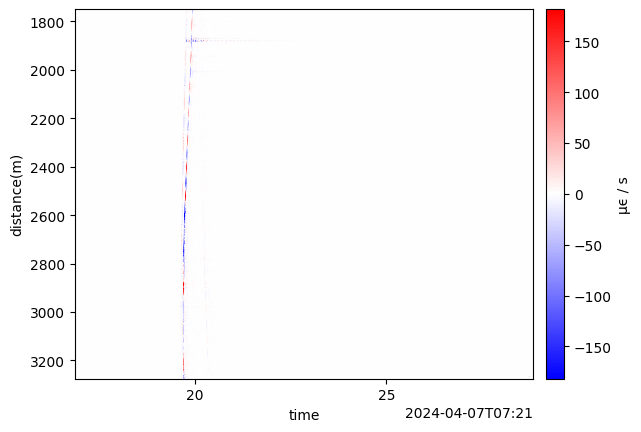

In [10]:
# ############ Load the catalog ############
import os 
import dascore as dc

# PARAMETERS
catalog_path_A = '/Users/danilodordevic/Desktop/Code/FORGE_bigstar/GES16Aand16BStimulationMonitoringApril2024/16AStimulationCatalogues'
catalog_path_B = '/Users/danilodordevic/Desktop/Code/FORGE_bigstar/GES16Aand16BStimulationMonitoringApril2024/16BStimulationCatalogues'

forge_path = '/bedrettolab/E1B/DAS/2024_FORGE/DATA_RAW_fromOpenei/April_2024/v1.0.0'

output_folder = 'data_statistics'
show_images = False
num_images = 5
width_mm = 85
dpi = 300
width_in = width_mm / 25.4
height_in = width_in * 0.75

# Load all events from the catalog and select the ones with the highest Moment Magnitude
dataframes = []
for file_name in os.listdir(catalog_path_A):
    file_path = os.path.join(catalog_path_A, file_name)
    if file_name.endswith('.csv') and file_name.startswith('FORGE'):
        df = pd.read_csv(file_path)
        if not df.empty:
            dataframes.append(df)

for file_name in os.listdir(catalog_path_B):
    file_path = os.path.join(catalog_path_B, file_name)
    if file_name.endswith('.csv') and file_name.startswith('FORGE'):
        df = pd.read_csv(file_path)
        if not df.empty:
            dataframes.append(df)

catalog_df = pd.concat(dataframes, ignore_index=True)
catalog_df.columns = catalog_df.columns.str.strip().str.replace(' ', '_')
catalog_df = catalog_df[catalog_df['Depth'] > 0]

# Plot one of the events you have locally
file_path = "das_files/16B_StrainRate_20240407T072116+0000_34572.h5"

try:
    patch = dc.spool(file_path)[0].transpose()
    patch.viz.waterfall(show=True, scale=0.05)
except Exception as e:
    print(f"Error loading {file_path}: {e}")

In [ ]:
# ########## Backprojection ##########
vp = 5.821*1000 # km/s -> m/s
vs = 3.414*1000 # km/s -> m/s

def backprojection(event, patch, vp, vs):